In [1]:
# J. Ryu, Electron Microscopy and Spectroscopy Lab., Seoul National University
from scipy import stats
from scipy.signal import periodogram
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf
import hyperspy.api as hys
from scipy import optimize
import ipywidgets as pyw
import time

In [2]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
# refer to "github.com/mkolopanis/python/blob/master/radialProfile.py"

def radial_stats(image, center=None, var=True):
   
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    #print(nr)
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    radial_avg  = (csim[rind[1:]] - csim[rind[:-1]]) / nr
    
    if var:    
        avg_square = np.square(radial_avg)
        square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
        mask = avg_square.copy()
        mask[np.where(avg_square==0)] = 1.0
        radial_var = (square_avg - avg_square) / mask
        return r, radial_avg, radial_var
    
    else:
        return r, radial_avg

In [4]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [5]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [6]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    stack = np.fromfile(img_adr, dtype=datatype)
    stack = stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [7]:
def fourd_roll_axis(stack):
    stack = np.rollaxis(np.rollaxis(stack, 2, 0), 3, 1)
    return stack

# load & prepare

In [8]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

D:/repository/data_repository/4D/20210131_IGZO_TZ/acquisition_1/scan_x256_y256.raw


In [10]:
datatype = "float32"
#o_shape = (128, 128, 130, 128)
#f_shape = (128, 128, 128, 128)
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

# load a data (RAW)
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
stack_4d = stack_4d / np.max(stack_4d) # normalize absolutely
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
1.0
1.6885593e-06
6.771043e-05


In [ ]:
# Load a data (DM)
stack_4d = hys.load(raw_adr).data
print(stack_4d.shape)
stack_4d = fourd_roll_axis(stack_4d)
f_shape = stack_4d.shape
print(f_shape)

stack_4d = stack_4d / np.max(stack_4d)
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))

In [ ]:
# rotate
stack_4d = np.rot90(stack_4d, 2, (0, 1))
f_shape = stack_4d.shape
print(f_shape.shape)

In [11]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (27.593506, 47.042857)
endposition  : (236.383117, 97.245455)


In [12]:
# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
cr_shape = stack_4d_cropped.shape
print(cr_shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))

(50, 209, 128, 128)
0.0040483098
4.3257296e-06
4.9926966e-05


In [ ]:
# just copy
stack_4d_cropped = stack_4d.copy()
cr_shape = stack_4d_cropped.shape
print(cr_shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))

In [13]:
%matplotlib inline

(50, 209)
0.0040483098
0.0019814682
0.0027787515
0.002681559


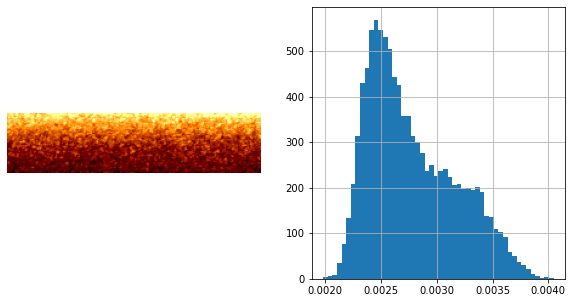

In [14]:
# maximum intensity distribution
max_int = np.max(stack_4d_cropped, axis=(2, 3))
print(max_int.shape)
print(np.max(max_int))
print(np.min(max_int))
print(np.mean(max_int))
print(np.median(max_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(max_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(max_int.flatten(), bins=len(max_int))
ax[1].grid()
plt.show()

(50, 209)
0.9154524
0.7604182
0.81800425
0.80859745


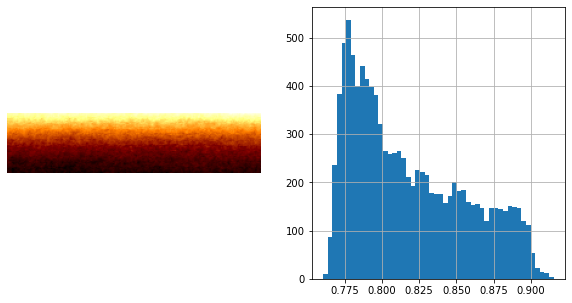

In [15]:
# total intensity distribution
tot_int = np.sum(stack_4d_cropped, axis=(2, 3))
print(max_int.shape)
print(np.max(tot_int))
print(np.min(tot_int))
print(np.mean(tot_int))
print(np.median(tot_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tot_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(tot_int.flatten(), bins=len(max_int))
ax[1].grid()
plt.show()

# center management

In [ ]:
%matplotlib inline

(50, 209, 2)
[63.92651042 64.05561428]


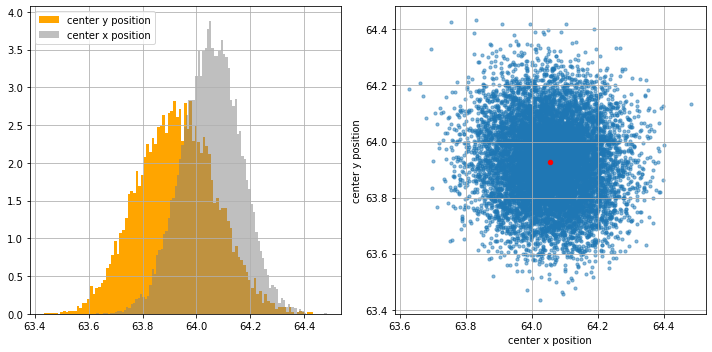

In [16]:
# find center position
center_pos = []
for i in range(cr_shape[0]):
    for j in range(cr_shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (cr_shape[0], cr_shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
ax[0].hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
ax[0].grid()
ax[0].legend()

ax[1].scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
ax[1].grid()
ax[1].scatter(center_mean[1], center_mean[0], s=20, c="red")
ax[1].set_xlabel("center x position", fontsize=10)
ax[1].set_ylabel("center y position", fontsize=10)
fig.tight_layout()
plt.show()

In [17]:
# remove center beam
center_radius = 10
for i in range(cr_shape[0]):
    for j in range(cr_shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))

0.00045973435
0.0
3.2075575e-05


# rotational average

In [ ]:
# radial average of DPs (not variance, intensity direcltly, RDF?)
radial_avg_stack = []
len_profile = []
for i in range(cr_shape[0]):
    for j in range(cr_shape[1]):
        _, radial_temp = radial_stats(stack_4d_cropped[i, j], center=center_mean.tolist(), var=False)
        len_profile.append(len(radial_temp))
        radial_avg_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(radial_avg_stack)):
        radial_avg_stack[i] = radial_avg_stack[i][:shortest]

radial_avg_stack = np.asarray(radial_avg_stack).reshape(cr_shape[0], cr_shape[1], -1)
print(radial_avg_stack.shape)

radial_avg_sum = np.sum(radial_avg_stack, axis=(0, 1))
print(radial_avg_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_avg_sum)
plt.grid()
plt.show()

In [ ]:
# save (radial average, 3D)
radial_avg_stack = hys.signals.Signal1D(radial_avg_stack)
radial_avg_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_avg_stack.save(raw_adr[:-4]+"_radial_avg_radial.hdf5")

# FEM (variance)

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

(89,)


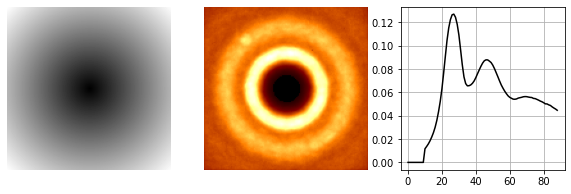

In [18]:
# obtain variance map dpending on k-vector
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
mask = avg_square.copy()
mask[np.where(avg_square == 0)] = 1.0
var_map = (square_avg - avg_square) / mask

# obtain radial average prifile for variance map above
radial_map, kp_var = radial_stats(var_map, center=center_mean.tolist(), var=False)
print(kp_var.shape)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(radial_map, cmap="gray")
ax[0].axis("off")
ax[1].imshow(var_map, cmap="afmhot")
ax[1].axis("off")
ax[2].plot(kp_var, "k-")
ax[2].grid()
plt.show()

In [ ]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(cr_shape[0]):
    for j in range(cr_shape[1]):
        _, _, radial_temp = radial_stats(stack_4d_cropped[i, j], center=center_mean.tolist(), var=True)
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

In [ ]:
# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial.hdf5")

# nano-cluster & HAADF-STEM

In [ ]:
def radial_indices(shape, radial_range, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1])
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r <= radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

In [ ]:
%matplotlib qt
fig = plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(2, 5)
ax0 = plt.subplot(G[0, 0])
ax1 = plt.subplot(G[0, 1])
ax2 = plt.subplot(G[0, 2])
ax3 = plt.subplot(G[1, 0])
ax4 = plt.subplot(G[1, 1])
ax5 = plt.subplot(G[1, 2])
ax6 = plt.subplot(G[:, 3:])

radii = np.arange(len(radial_var_sum))
#pacbed = np.mean(stack_4d_cropped, axis=(0, 1))
pacbed = np.mean(stack_4d_cropped, axis=(0, 1))
def var_selector(di, do, uth, lth, k1, k2, p1, p2):
    
    v1 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p1)
    v2 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p2)
    
    ax0.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    ax5.cla()
    ax6.cla()

    ax0.plot(radii, radial_var_sum, "k-", c="black")
    ax0.fill_between([k1, k2], np.max(radial_var_sum), alpha=0.5, color="orange")
    ax0.set_title("rotational variance profile")
    ax0.grid()
    
    masked = radial_var_stack[:, :, k1:(k2+1)]
    binsize = masked.shape[0]*masked.shape[1]
    ax1.hist(masked.flatten(), bins=binsize, color="darkgray")
    ax1.fill_between([v1, v2], ax1.get_ylim()[1], alpha=0.5, color="orange")
    ax1.set_title("variance histogram for a selected k-range")
    ax1.grid()
    
    bool_img = np.ones_like(masked)
    bool_img[np.where(masked < v1)] = 0
    bool_img[np.where(masked > v2)] = 0
    img = np.sum(bool_img, axis=2)
    ax2.imshow(img, cmap="afmhot")
    ax2.set_title("variance map, larger than threshold")
    ax2.axis("off")
    
    if di > do:
        det = [do, di]
        print("Warning! detector 1 (inner angle > outer angle)")
    else:
        det = [di, do]
        
        
    ri = radial_indices(f_shape[2:], det, center=center_mean.tolist())
    
    ax3.imshow(pacbed, cmap="gray")
    ax3.imshow(ri, cmap="Reds", alpha=0.3)
    ax3.set_title("detector range")
    ax3.axis("off")
    
    stem = np.sum(np.multiply(stack_4d_cropped, ri), axis=(2, 3))
    ax4.imshow(stem, cmap="afmhot")
    ax4.set_title("STEM image")
    ax4.axis("off")
    
    stem_bool = np.ones_like(stem)
    stem_bool[np.where(stem > np.percentile(stem, uth))] = 0.0
    stem_bool[np.where(stem <= np.percentile(stem, lth))] = 0.0
    
    ax5.imshow(stem_bool, cmap="summer")
    ax5.set_title("STEM, larger than threshold")
    ax5.axis("off")

    ax6.imshow(stem_bool, cmap="summer")
    ax6.imshow(img, cmap="afmhot", alpha=0.3)
    ax6.set_title("variance vs. STEM")
    ax6.axis("off")
    
    fig.canvas.draw()
    fig.tight_layout()

st = {"description_width": "initial"}
din = pyw.IntText(value=25, description="D1 inner angle: ", style=st)
dout = pyw.IntText(value=30, description="D1 outer angle: ", style=st)
up_th = pyw.IntText(value=10, description="STEM upper threshold: ", style=st)
lo_th = pyw.IntText(value=0, description="STEM lower threshold: ", style=st)
k1_widget = pyw.IntText(value=25, description="left of k-range", style=st)
k2_widget = pyw.IntText(value=30, description="right of k-range", style=st)
p1_widget = pyw.FloatText(value=90.0, description="left percentile of variance range", style=st)
p2_widget = pyw.FloatText(value=99.999, description="right percentile of variance range", style=st)

pyw.interact(var_selector, di=din, do=dout, uth=up_th, lth=lo_th, k1=k1_widget, k2=k2_widget, p1=p1_widget, p2=p2_widget)
fig.show()

# angular correlation

In [ ]:
%matplotlib inline

In [19]:
def round_step(arr, step_size=1):
    
    divide = np.around(arr / step_size)
    rounded = divide * step_size
    
    return rounded

In [20]:
def point_circle(image, radius, center=None):
    
    y, x = np.indices(image.shape)
    y = y.astype("float64")
    x = x.astype("float64")
    
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    y -= center[0]
    x -= center[1]
    
    angle_arr = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j], y[i, j]), deg=True)
            
    angle_arr = angle_arr + 180
    #print(angle_arr)
    r = np.hypot(y, x)
    r = np.around(r)
    ri = np.where(r == radius)
    angle_sel = angle_arr[ri]
    value_sel = image[ri]

    return angle_arr, angle_sel, value_sel

In [21]:
# angle unit [degree]
def angular_correlation(angles, values):
    angle_diff = []
    corr_values = []
    angle_diff_candidates = np.arange(0, 361, 1)
    corr_val_total = np.zeros(angle_diff_candidates.shape)
    
    int_sqavg = np.square(np.mean(values))
    
    for i in range(len(angles)):
        temp_diff = np.abs(angles[i:] - angles[i])
        temp_diff = round_step(temp_diff)
        corr_temp = values[i:] * values[i]

        angle_diff.extend(temp_diff.tolist())
        corr_values.extend(corr_temp.tolist())
        
    angle_diff = np.asarray(angle_diff)
    corr_values = np.asarray(corr_values)
    
    uni_angle = np.unique(angle_diff)
    #print(uni_angle)
    
    for ang in uni_angle:
        temp_ind = np.where(angle_diff==ang)
        corr_val_total[int(ang)] = np.mean(corr_values[temp_ind]) / int_sqavg - 1

    return corr_val_total

In [22]:
start_time = time.process_time()
angular_corr = []
angle_range = np.arange(0, 361, 1)
k_range = np.arange(26, 29, 1)
print(k_range.shape)
for k in k_range:
    temp = []
    for i in range(cr_shape[0]):
        for j in range(cr_shape[1]):
            angle_map, angle_sel, value_sel = point_circle(stack_4d_cropped[i, j], k, center=center_mean.tolist())
            ang_cor = angular_correlation(angle_sel, value_sel)
            temp.append(ang_cor)
    angular_corr.append(temp)
    print("%d radius completed"%(k))
    print("%d seconds have passed"%(time.process_time()-start_time))
print("all done")

(3,)
26 radius completed
747 seconds have passed
27 radius completed
1460 seconds have passed
28 radius completed
2210 seconds have passed
all done


In [23]:
angular_corr = np.asarray(angular_corr).reshape(len(k_range), cr_shape[0], cr_shape[1], -1)
print(angular_corr.shape)
ang_corr_sum = np.sum(angular_corr, axis=(1, 2))
print(ang_corr_sum.shape)

(3, 50, 209, 361)
(3, 361)


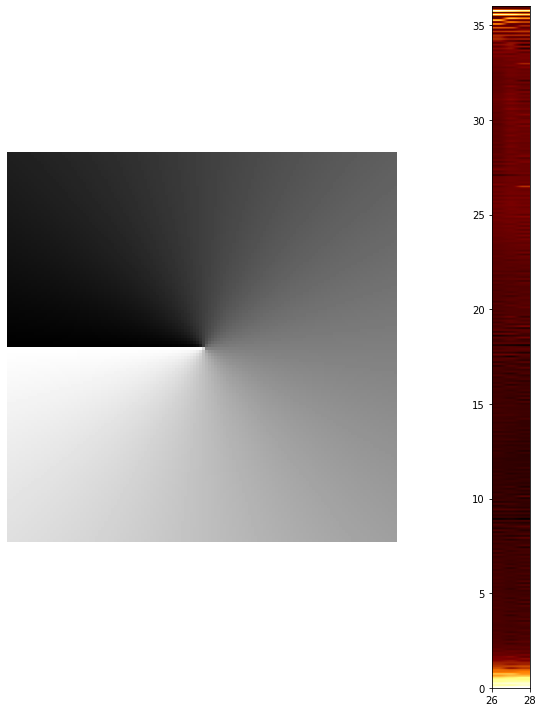

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(angle_map, cmap="gray")
ax[0].axis("off")
ax[1].imshow(np.flip(ang_corr_sum.T, 0), cmap="afmhot", extent=[k_range[0], k_range[-1], angle_range[0]/10, angle_range[-1]/10])
fig.tight_layout()
plt.show()

In [25]:
ang_corr_fft= np.abs(np.fft.fft(angular_corr))
print(ang_corr_fft.shape)
ang_corr_fft_sum = np.abs(np.fft.fft(ang_corr_sum))
print(ang_corr_fft_sum.shape)
pow_sp = periodogram(ang_corr_sum)
print(pow_sp[1].shape)

(3, 50, 209, 361)
(3, 361)
(3, 181)


In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

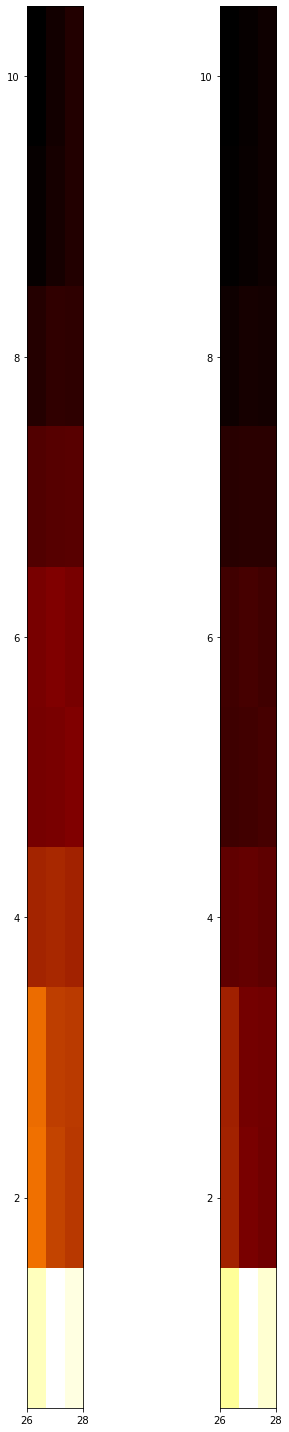

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(7, 20))
ax1 = ax[0].imshow(np.flip(ang_corr_fft_sum[:, 1:11].T, 0), cmap="afmhot", 
                   extent=[k_range[0], k_range[-1], 0.5, 10.5], aspect=5, 
                   vmax=np.max(ang_corr_fft_sum))
ax2 = ax[1].imshow(np.flip(pow_sp[1][:, 1:11].T, 0), cmap="afmhot", 
                   extent=[k_range[0], k_range[-1], 0.5, 10.5], aspect=5, 
                   vmax=np.max(pow_sp[1]))
fig.tight_layout()
plt.show()